# DSP report: Separate vocals from songs
## Digital Signal Processing project
### Lecturer: Tung Tran Hoang


### Our team members:
- Hieu Pham Minh BI11-090
- Son Le Thach BI11-238
- Thiep Pham Huy BI11-255
- Thong Le Dinh BI11-257

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.io import wavfile
import contextlib

## Interpreting WAV Data

In [2]:
def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte shortp
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels

## Get start end frames

In [3]:
def get_start_end_frames(nFrames, sampleRate, tStart=None, tEnd=None):

    if tStart and tStart*sampleRate<nFrames:
        start = tStart*sampleRate
    else:
        start = 0

    if tEnd and tEnd*sampleRate<nFrames and tEnd*sampleRate>start:
        end = tEnd*sampleRate
    else:
        end = nFrames

    return (start,end,end-start)

## Extract audio

In [4]:
def extract_audio(fname, tStart=None, tEnd=None):
    with contextlib.closing(wave.open(fname,'rb')) as spf:
        sampleRate = spf.getframerate()
        ampWidth = spf.getsampwidth()
        nChannels = spf.getnchannels()
        nFrames = spf.getnframes()

        startFrame, endFrame, segFrames = get_start_end_frames(nFrames, sampleRate, tStart, tEnd)

        # Extract Raw Audio from multi-channel Wav File
        spf.setpos(startFrame)
        sig = spf.readframes(segFrames)
        spf.close()

        channels = interpret_wav(sig, segFrames, nChannels, ampWidth, True)

        return (channels, nChannels, sampleRate, ampWidth, nFrames)

## Convert to mono

In [5]:
def convert_to_mono(channels, nChannels, outputType):
    if nChannels == 2:
        samples = np.mean(np.array([channels[0], channels[1]]), axis=0)  # Convert to mono
    else:
        samples = channels[0]

    return samples.astype(outputType)

## Plot specgram

In [6]:
def plot_specgram(samples, sampleRate, tStart=None, tEnd=None):
    plt.figure(figsize=(20,10))
    plt.specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

## Plot audio samples

In [7]:
def plot_audio_samples(title, samples, sampleRate, tStart=None, tEnd=None):
    if not tStart:
        tStart = 0

    if not tEnd or tStart>tEnd:
        tEnd = len(samples)/sampleRate

    f, axarr = plt.subplots(2, sharex=True, figsize=(20,10))
    axarr[0].set_title(title)
    axarr[0].plot(np.linspace(tStart, tEnd, len(samples)), samples)
    axarr[1].specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    #get_specgram(axarr[1], samples, sampleRate, tStart, tEnd)

    axarr[0].set_ylabel('Amplitude')
    axarr[1].set_ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    plt.show()

## FIR high pass

In [8]:
#!ffmpeg -y -loglevel panic -i sultans_20s.wav sultans_20s.mp3
def fir_high_pass(samples, fs, fH, N, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs

    # Compute sinc filter.
    h = np.sinc(2 * fH * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Create a high-pass filter from the low-pass filter through spectral inversion.
    h = -h
    h[int((N - 1) / 2)] += 1
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

## FIR low pass

In [9]:
def fir_low_pass(samples, fs, fL, N, outputType):
    # Referece: https://fiiir.com

    fL = fL / fs

    # Compute sinc filter.
    h = np.sinc(2 * fL * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

## Filter methods

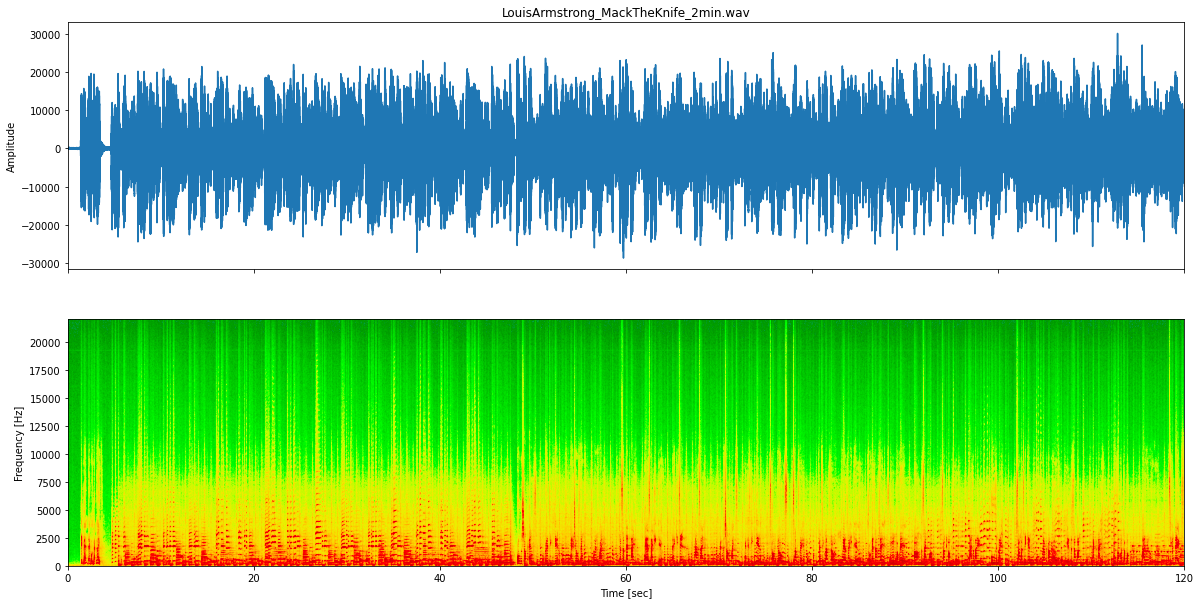

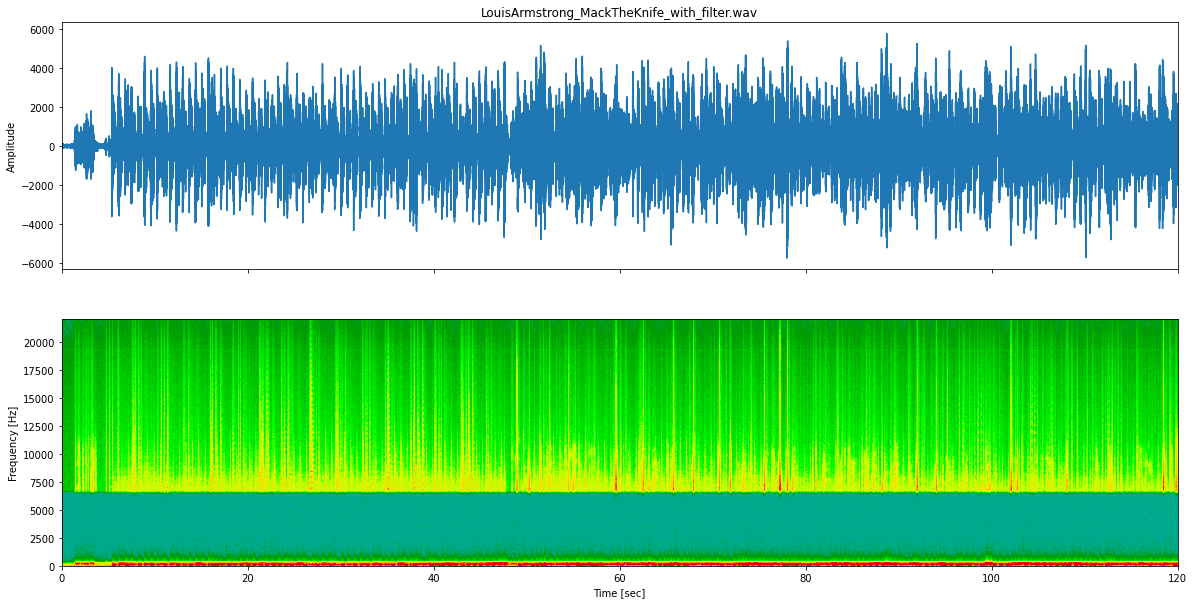

In [10]:
tStart=0
tEnd=120
channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('LouisArmstrong_MackTheKnife.wav', tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

plot_audio_samples("LouisArmstrong_MackTheKnife_2min.wav", samples, sampleRate, tStart, tEnd)

wavfile.write('LouisArmstrong_MackTheKnife_mono.wav', sampleRate, samples)


lp_samples_filtered = fir_low_pass(samples, sampleRate, 300, 461, np.int16)               # First pass
lp_samples_filtered = fir_low_pass(lp_samples_filtered, sampleRate, 250, 461, np.int16)   # Second pass

hp_samples_filtered = fir_high_pass(samples, sampleRate, 6600, 461, np.int16)             # First pass
hp_samples_filtered = fir_high_pass(hp_samples_filtered, sampleRate, 6600, 461, np.int16) # Second pass

samples_filtered = np.mean(np.array([lp_samples_filtered, hp_samples_filtered]), axis=0).astype(np.int16)

plot_audio_samples("LouisArmstrong_MackTheKnife_with_filter.wav", samples_filtered, sampleRate, tStart, tEnd)

wavfile.write("LouisArmstrong_MackTheKnife_with_filter.wav", sampleRate, samples_filtered)

## Mix channel

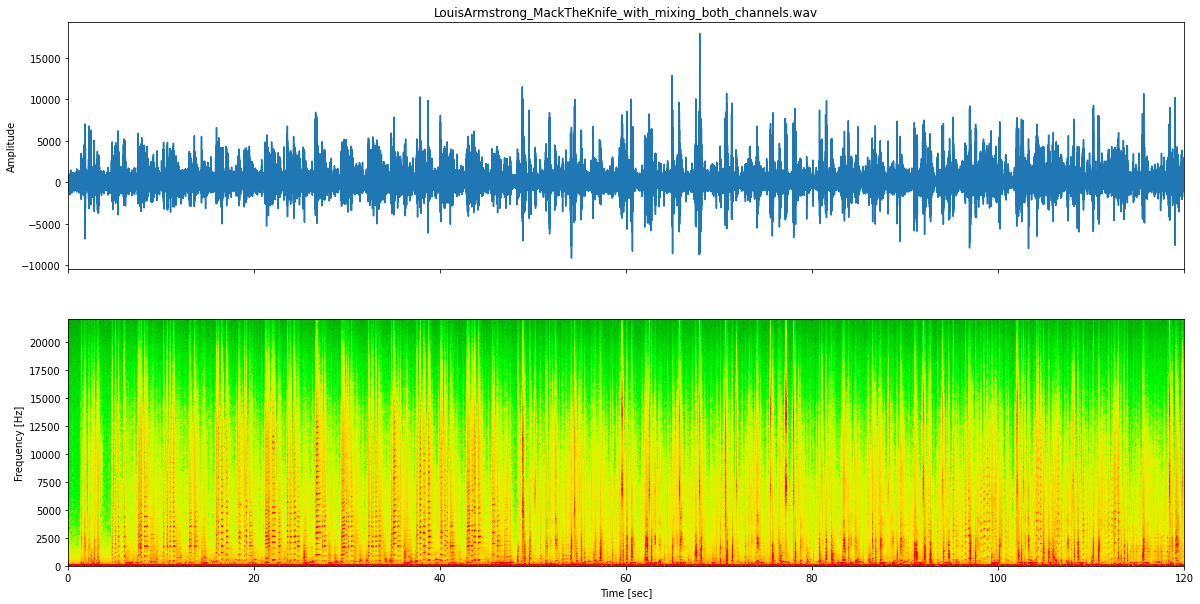

In [11]:
channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('LouisArmstrong_MackTheKnife.wav', tStart, tEnd)
samples_no_voice = (channels[0]-channels[1]).astype(np.int16)

plot_audio_samples("LouisArmstrong_MackTheKnife_with_mixing_both_channels.wav", samples_no_voice, sampleRate, tStart, tEnd)

wavfile.write("LouisArmstrong_MackTheKnife_with_mixing_both_channels.wav", sampleRate, samples_no_voice)

## Mixing both methods above

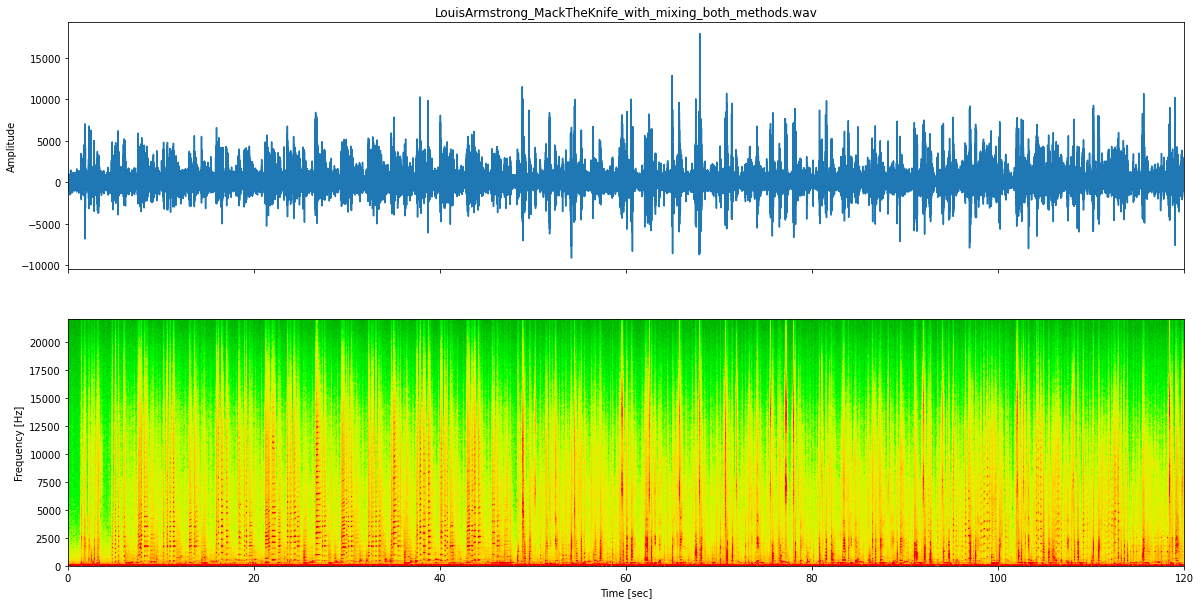

In [12]:
lp_samples_filtered.resize(samples_no_voice.shape)
hp_samples_filtered.resize(samples_no_voice.shape)

samples = ((samples_no_voice+lp_samples_filtered+hp_samples_filtered)/3).astype(np.int16)
plot_audio_samples("LouisArmstrong_MackTheKnife_with_mixing_both_methods.wav", samples_no_voice, sampleRate, tStart, tEnd)

wavfile.write("LouisArmstrong_MackTheKnife_with_mixing_both_methods.wav", sampleRate, samples_no_voice)

In [13]:
wavfile.write('LouisArmstrong_MackTheKnife_test2.wav', sampleRate, samples_filtered)
#!ffmpeg -y -loglevel panic -i sultans_novoice1.wav sultans_novoice1.mp3